# Self-Driving Car Engineer Nanodegree


## Code: **Lane Line Finding Advanced** 

In [1]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

%matplotlib inline
#%matplotlib qt

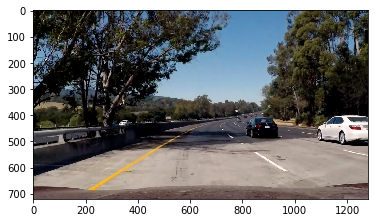

In [107]:
# read in calibration images

images = glob.glob('camera_cal/calibration*.jpg')
# read in the test image on which we will test the camera calibration
image_test = cv2.imread('camera_cal/calibration1.jpg')
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
# read in the image on which we will do the transformations
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)


The camera matrix is:
[[1.15158804e+03 0.00000000e+00 6.66167057e+02]
 [0.00000000e+00 1.14506859e+03 3.86440204e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
The distortion coefficients are:
[[-2.35510339e-01 -7.90388401e-02 -1.28492203e-03  8.25970403e-05
   7.22743173e-02]]


True

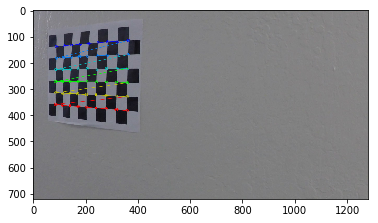

In [108]:
# 1) Calibrate the camera

# arrays to store object and image points from all the images
objpoints = []     # 3D points in real world space (only 1 set of numbers as there is only 1 real item)
imgpoints = []     # 2D points in image plane (from all the images taken)

# prepare object points, like (0,0,0), (1,0,0), ... and (7,5,0)
objp = np.zeros((6*9,3),np.float32) #changed size to 6*9
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)   # generate x and y coordinates

for fname in images:
    # read in each image
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # prepare image points using CV functions. These functions need the image in grayscale as input
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find the chessboard corners of the images used for calibration
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    # if corners are detected, append both objp and the deteced image points to their arrays
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
# draw and display the last image with the corners
img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
plt.imshow(img)
cv2.imwrite('output_images/cal_image.jpg',img)
# actual camera calibration using 'calibrateCamera' function;
# calculates 'dist' (distortion coefficients),       'mtx' (camera matrix to transform 3D object points to 2D image points), 
#            'rvecs' (rotation position in world),   'tvecs' (translation position in world)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print('The camera matrix is:')
print(mtx)
print('The distortion coefficients are:')
print(dist)

dst = cv2.undistort(image_test,mtx,dist,None,mtx)
cv2.imwrite('output_images/cal_done_image.jpg',dst)

In [53]:
# with function'undistort' we take the distorted image and using the camera matrix and the distortion coefficients, it
# returns an undistorted image called 'destination'.
def undistort(image,mtx,dist):
    dst = cv2.undistort(image,mtx,dist,None,mtx)
    #print('The undistorted image is:')
    #plt.imshow(dst)
    return dst

In [5]:
# the above calibration and undistortion needs to be done only once but with good quality images.

In [79]:

def pipeline(img, r_thresh=(200,255),Lthresh=(215,255),lab_bthresh=(145,200),s_thresh=(170, 255), sx_thresh=(10, 160), sy_thresh=(10, 160),l_thresh=(220, 255)):#190 255
    img = np.copy(img)
    
    #RGB R channel--ACTUALLY USE B IS BETTER??
    r_channel=img[:,:,1] #1
    
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    #convert to LUV-L channel--ACTUALLY USE U IS BETTER??
    LUV=cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    Lchannel = LUV[:,:,1] #1
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0,ksize=3)             # Take the derivative in x based on the s-channel
    abs_sobelx = np.absolute(sobelx)                            # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelX = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1,ksize=3)             # Take the derivative in y based on the s-channel
    abs_sobely = np.absolute(sobely)                            # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelY = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold R
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Threshold L
    Lbinary = np.zeros_like(Lchannel)
    Lbinary[(Lchannel >= Lthresh[0]) & (Lchannel <= Lthresh[1])] = 1
    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelX)
    sxbinary[(scaled_sobelX >= sx_thresh[0]) & (scaled_sobelX <= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobelY)
    sybinary[(scaled_sobelY >= sy_thresh[0]) & (scaled_sobelY <= sy_thresh[1])] = 1
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold l channel-HLS
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    
    #LAB-b channel
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
   
    B_binary = np.zeros_like(lab_b)
    B_binary[((lab_b > lab_bthresh[0]) & (lab_b <= lab_bthresh[1]))] = 1
    
    # Combine LUV-L ,Lab B,RGB R channel thresholds
    combined = np.zeros_like(B_binary)
    #combined[(sxbinary == 1) & (sybinary == 1)] = 1
    combined[(r_binary == 1) | (B_binary == 1)|(Lbinary == 1)] = 1
  
    #color_binary=np.dstack((combined*255, combined*255, combined*255))
    return combined

In [80]:
# pipeline to warp the selected area
# define perspective transformation function
def warp(img):
    # define calibration box in source (original) and destimation (desired or warped) coordinates
    img_size = (img.shape[1],img.shape[0])
    # 4 source coordinates
    src = np.float32(
        [[700,460],     # top right
        [1110,700],     # bottom right
        [ 325,700],     # bottom left
        [ 568,460]])    # top left
    # 4 desired (warped) coordinates -> chosen manually by eyeballing the image
    dst = np.float32(
        [[1100,0],
        [1100,700],
        [ 200,700],
        [ 200,0]])
    # compute the perspective transform which returns a matrix 
    # if we change place for src and dst we can do the inverse transform (as a note)
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # create warped image using linear transformation
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    warped_im_gray = warped#cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    
    return warped,warped_im_gray,Minv

In [81]:
# detecting the lanes based on the warped binary image

# The first step we'll take is to split the histogram into two sides, one for each lane line.
def find_lane_pixels(binary_warped):
    # histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # set HYPERPARAMETERS related to the sliding windows. Set them up to iterate across the binary activations in the image.
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # iterate through nwindows to track curvature
    # above sets up what the windows look like and gives a starting point. Now, we'll loop through nwindows, with the given 
    # window sliding left or right if it finds the mean position of activated pixels within the window to have shifted.
    
    # 1. Loop through each window in nwindows
    for window in range(nwindows):
        # 2. Find the boundaries of our current window in x and y (and right and left). This is based on a combination of 
        # the current window's starting point (leftx_current and rightx_current), as well as the margin you set in the 
        # hyperparameters.
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # 3. Use cv2.rectangle to draw these window boundaries onto our visualization image out_img. You can skip this step 
        # in practice if you don't need to visualize where the windows are.
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # 4. Now that we know the boundaries of our window, find out which activated pixels from nonzeroy and nonzerox  
        # actually fall into the window.
        good_left_inds  = ((nonzeroy >= win_y_low)      &  (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xleft_low)  &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low)      &  (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # 5. Append these to our lists left_lane_inds and right_lane_inds.
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # 6. If the number of pixels you found in Step 4 are greater than your hyperparameter minpix, re-center our window 
        # (i.e. leftx_current or rightx_current) based on the mean position of these pixels.
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # PR22: Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [96]:
# Fit a polynomial
# We have now found all our pixels belonging to each line through the sliding window method, it's time to fit a 
# polynomial to the line.

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit  = np.polyfit(lefty,  leftx,  2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

        

    left_fit_cr  = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)   
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2) 

        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty,  leftx]  = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    
    return out_img, ploty, left_fitx, right_fitx, left_fit_cr, right_fit_cr

In [97]:
# Curvature calculation
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

In [99]:
def measure_curvature_real(out_img,ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''    
   
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #height of the real image
    h=out_img.shape[0]*ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Distance from center
    if left_fit_cr is not None and right_fit_cr is not None:
        car_position = out_img.shape[1]*xm_per_pix/2
        left_fit_cr_int = left_fit_cr[0]*h**2 + left_fit_cr[1]*h + left_fit_cr[2]
        right_fit_cr_int = right_fit_cr[0]*h**2 + right_fit_cr[1]*h + right_fit_cr[2]
        lane_center_position = (left_fit_cr_int + right_fit_cr_int) /2
        center_dist = (car_position - lane_center_position)
        
    return left_curverad, right_curverad,center_dist

In [100]:
# Create an image to draw the lines on
def drawline(warped_im_gray,left_fit,right_fit,ploty,Minv,dst):
    warp_zero = np.zeros_like(warped_im_gray).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(dst, 1, newwarp, 0.5, 0)
    plt.imshow(result)
    return result

In [101]:
def draw_data(original_img, leftCurv ,rightCurv,center_dist):
  
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text1 = 'Right Curve radius: ' + '{:04.2f}'.format(rightCurv) + 'm'
    text2 = 'Left Curve radius: ' + '{:04.2f}'.format(leftCurv) + 'm'
    cv2.putText(new_img, text1, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(new_img, text2, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,170), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    plt.imshow(new_img)
    return new_img



In [103]:
def process_image(image_new):

    #uncomment following line for saving images
    #for i in range(1,7):
    #image = cv2.imread('test_images/test'+str(i)+'.jpg')
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image_new=image
    mtx=np.array([[1.15158804e+03,0.00000000e+00,6.66167057e+02],[0.00000000e+00,1.14506859e+03,3.86440204e+02],[0.00000000e+00,0.00000000e+00,1.00000000e+00]])
    dist=np.array([[-2.35510339e-01,-7.90388401e-02,-1.28492203e-03,8.25970403e-05,7.22743173e-02]])
    undist_img=undistort(image_new,mtx,dist)
    plt.imshow(undist_img)
    # cv2.imwrite('output_images_temp/undistorted_image'+str(i)+'.jpg',cv2.cvtColor(undist_img, cv2.COLOR_RGB2BGR))
    #plt.imshow(undist_img)
    
    mask=pipeline(undist_img)
    color_binary=np.dstack((mask*255, mask*255, mask*255))
    #plt.imshow(color_binary,cmap='gray')
    #cv2.imwrite('output_images_temp/binary_image'+str(i)+'.jpg',color_binary)

    # pipeline to warp the selected area
    # define perspective transformation function
    warpped,warpped_gray,Minv=warp(mask)

    color_warpped=np.dstack((warpped*255, warpped*255, warpped*255))
    #cv2.imwrite('output_images_temp/warpped_image'+str(i)+'.jpg',color_warpped)
    #plt.imshow(color_warpped,cmap='gray')

    out_img, ploty, left_fit, right_fit, left_fit_cr, right_fit_cr = fit_polynomial(warpped_gray)

    #cv2.imwrite('output_images_temp/ploy'+str(i)+'.jpg',out_img)
    #plt.imshow(out_img)

    # Curvature calculation
    left_curv,right_curv=measure_curvature_pixels(ploty, left_fit, right_fit)
    left_curv_real,right_curv_real,ctr_dist=measure_curvature_real(out_img, ploty, left_fit_cr, right_fit_cr)
    #drawline
    new_img=drawline(warpped_gray,left_fit,right_fit,ploty,Minv,undist_img)
    result=draw_data(new_img,left_curv_real,right_curv_real,ctr_dist)

    #below code is just for saving the image (imwrite default colormap is BGR)

    #cv2.imwrite('output_images_temp/result'+str(i)+'.jpg',cv2.cvtColor(result, cv2.COLOR_RGB2BGR))



    plt.imshow(result)
    return result

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#test on video
video_output = 'project_video_output_01.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,2)



white_clip = clip1.fl_image(process_image)#NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output_01.mp4
[MoviePy] Writing video project_video_output_01.mp4


100%|█████████▉| 1260/1261 [13:53<00:00,  1.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_01.mp4 

CPU times: user 30min 47s, sys: 4min 23s, total: 35min 11s
Wall time: 13min 58s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))